In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import time

In [2]:
DataSet = pd.read_hdf(r'DataFrame_Output.h5')
print(DataSet.head())

                                            Features  Len  Label
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   36      0
1  [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   35      0
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   35      0
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   22      0
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   81      0


In [3]:
# 统计 'Len' 列中每个序列长度值的出现次数
Len_Counts = DataSet['Len'].value_counts()

# 将统计结果重置索引，并转换为 DataFrame
len_counts_df = Len_Counts.reset_index()

# 'reset_index()' 将原来的索引（即长度值）变成一列，同时生成一个新的默认整数索引
# 结果是一个 DataFrame，有两列：'index' 和 'Len' 
# 第一列 'index' 是原来的序列长度值
# 第二列 'Len' 是每个序列长度对应的出现次数

# 遍历重置索引后的 DataFrame，打印每种序列长度及其出现次数
for i in range(len(len_counts_df)):
    print(len_counts_df['index'][i], len_counts_df['Len'][i])

# 上面的循环遍历 len_counts_df 中的每一行
# 'len_counts_df['index'][i]' 获取序列长度
# 'len_counts_df['Len'][i]' 获取该长度出现的次数
# 打印格式为：长度值 出现次数


61 2935
87 2129
133 1339
262 899
130 819
74 796
59 784
36 732
53 628
57 601
78 585
108 572
62 528
56 528
60 524
89 517
50 501
54 494
55 494
58 492
81 491
103 481
68 479
41 452
83 446
85 429
127 421
77 420
47 414
35 410
48 406
79 393
64 390
71 389
82 366
46 355
52 352
93 352
80 351
70 350
72 344
51 343
86 326
128 324
67 323
75 319
44 316
73 315
105 314
34 310
117 307
155 306
63 305
49 299
92 288
65 277
33 273
131 273
69 267
95 265
96 258
43 255
118 254
66 245
45 244
84 238
126 235
91 225
124 215
76 215
115 213
111 212
99 208
98 207
102 201
42 199
94 198
97 196
101 190
88 189
122 183
114 182
119 182
107 182
120 181
40 181
129 180
39 177
259 175
38 172
90 171
116 167
106 167
100 166
150 165
113 164
104 163
112 161
125 160
32 154
253 147
165 146
132 144
147 143
31 143
121 138
160 136
110 132
37 127
109 126
255 124
261 124
260 123
605 122
252 121
183 117
123 117
258 114
250 112
256 109
236 109
247 108
195 105
257 105
241 96
142 95
238 94
278 94
254 94
251 93
172 92
149 92
143 88
229 87
249 

In [4]:
root_path = r'.\data\train_data\DataSet'
Data_Path = []
for root, dirs, files in os.walk(root_path):
    # print(root, dirs, files)
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(root, file)
            # print(root, "file_path:", file_path)
            Data_Path.append(file_path)
# 初始化空的列表来存储数据
features_list = []
len_list = []
label_list = []
# 直接在循环中处理数据
for data_path in Data_Path:
    Features = np.loadtxt(data_path, delimiter=' ')
    # 直接将Features作为列表存储，不创建Features_List
    features_list.append(Features)
    # 计算Features长度并存储
    len_list.append(len(Features))
    # 提取label并存储，注意处理可能的数据类型转换
    label = int(data_path.split('\\')[-2][-1])
    label_list.append(label)
# 使用列表创建DataFrame
DataSet = pd.DataFrame({
    'Features': features_list,
    'Len': len_list,
    'Label': label_list
})
print(DataSet.head())

                                            Features  Len  Label
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   36      0
1  [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   35      0
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   35      0
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...   22      0
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   81      0


In [5]:
# 将 DataFrame 转换为 PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        features = self.df.iloc[idx]['Features']
        label = self.df.iloc[idx]['Label']
        length = self.df.iloc[idx]['Len']
        return features, label
# 转换 DataFrame 为 Dataset 对象
dataset = CustomDataset(DataSet)

In [6]:
print(dataset[1])

(array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.50997571, -2.41522946,  1.03267646, -2.53044718, -0.92936818],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.30134929,  0.        , -1.09342213, -0.11745769,  1.5404171 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [7]:
# 根据 Label 列来分层划分数据集
train_dataset, test_dataset = train_test_split(dataset, test_size=0.3, stratify=dataset.df['Label'], random_state=42)

In [8]:
print(train_dataset[0])

(array([[ 0.        ,  0.        ,  0.        , ..., -0.92907139,
        -0.03003971,  0.48317854],
       [ 0.        ,  0.        ,  0.        , ...,  1.16883175,
        -0.03003971, -0.25943119],
       [ 0.        ,  0.        ,  0.        , ..., -0.92907139,
        -0.03003971,  1.1582783 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.11988018,
         1.61454283,  0.23564196],
       [ 0.        ,  0.        ,  0.        , ..., -0.92907139,
        -0.03003971,  1.1582783 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.16883175,
         2.90556691, -2.90357192]]), 2)


In [43]:
def collate_fn(batch):
    features, labels = zip(*batch)
    # 确保 features 中的每个元素都是一个形状为 [Len, 25] 的二维张量
    features = [torch.tensor(f, dtype=torch.float) for f in features]
    # 获取每个序列的实际长度
    lengths = [f.size(0) for f in features]
    # 对长度进行降序排序，并记录排序的索引
    sorted_lengths, sorted_indices = torch.sort(torch.tensor(lengths), descending=True)
    # 使用排序后的索引对features_padded进行排序
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    features_padded = features_padded.index_select(0, sorted_indices)
    # 打包填充后的序列
    packed_features = pack_padded_sequence(features_padded, sorted_lengths, batch_first=True, enforce_sorted=True)
    labels = torch.tensor(labels).index_select(0, sorted_indices)  # 确保标签与排序后的序列匹配
    return packed_features, sorted_lengths, labels, sorted_indices

In [44]:
def Data_Loader(train_dataset, test_dataset, batch_size, collate_fn):
    # 创建 DataLoader
    Batch_Size = batch_size
    Train_loader = DataLoader(train_dataset, batch_size=Batch_Size, collate_fn=collate_fn)
    Test_loader = DataLoader(test_dataset, batch_size=Batch_Size, collate_fn=collate_fn)
    return Train_loader, Test_loader

In [48]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # 添加Dropout层
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # 修改后的forward方法
    def forward(self, x, lengths):
        # x 是一个 PackedSequence 对象
        batch_size = len(lengths)
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        # 前向传播LSTM，接受 PackedSequence 输入
        out, (h_n, c_n) = self.lstm(x, (h0, c0))
        # 解包PackedSequence
        out, _ = pad_packed_sequence(out, batch_first=True)
        # 选择每个序列的最后一个有效输出
        last_time_indices = (lengths - 1).unsqueeze(1).expand(-1, out.size(2)).to(self.device)  
        # print(np.shape(last_time_indices))
        # 使用gather选择最后一个时间步的输出
        out = out.gather(1, last_time_indices.unsqueeze(1)).squeeze(1)
        # print(np.shape(out))
        # 通过Dropout层
        out = self.dropout(out)
        # 通过全连接层
        out = self.fc(out)
        return out

In [49]:
def train_model2(device, model, traindataloader, valdataloader,criterion, optimizer, batch_size, hidden_size, lr, num_layers, dropout, num_epochs=25):
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    Best_Accuracy = 0.0
    Best_Weights_Name = 'Best_LSTM_Weights_BatchSize-{}_HiddenSize-{}_lr-{}_{}Layers_Dropout-{}_{}Epochs.pth'.format(batch_size, hidden_size, lr, num_layers, dropout, num_epochs)
    for epoch in range(num_epochs):
        print('-' * 15)
        print('第 {}/{} 轮训练'.format(epoch + 1, num_epochs))
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        model.to(device)
        model.train()
        for step, (inputs, lengths, targets, _) in enumerate(traindataloader):
            inputs, lengths, targets = inputs.to(device), lengths.to(device), targets.to(device)
            out = model(inputs, lengths)
            pre_lab = torch.argmax(out, 1)
            loss = criterion(out, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * targets.size(0)
            train_corrects += torch.sum(pre_lab == targets)
            train_num += targets.size(0)
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        print('第 {} 轮训练 - 训练损失: {:.4f} - 训练精度: {:.4f}'.format(epoch+1, train_loss_all[-1], train_acc_all[-1]))
        model.eval()
        with torch.no_grad():
            for (inputs, lengths, targets, _) in valdataloader:
                inputs, lengths, targets = inputs.to(device), lengths.to(device), targets.to(device)    
                out = model(inputs, lengths)
                pre_lab = torch.argmax(out, 1)
                loss = criterion(out, targets)
                val_loss += loss.item() * targets.size(0)
                val_corrects += torch.sum(pre_lab == targets)
                val_num += targets.size(0)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)
        print('第 {} 轮训练 - 验证损失: {:.4f} - 验证精度: {:.4f}'.format(epoch+1, val_loss_all[-1], val_acc_all[-1]))
        
        if val_acc_all[-1] >= Best_Accuracy:
            Best_Accuracy = val_acc_all[-1]    
            torch.save(model.state_dict(), Best_Weights_Name)
    
    train_process = pd.DataFrame(
        data={"epoch": range(num_epochs),
              "train_loss_all": train_loss_all,
              "train_acc_all": train_acc_all,
              "val_loss_all": val_loss_all,
              "val_acc_all": val_acc_all})
    time_elapsed = time.time() - since
    print('训练完成，总耗时 {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model, train_process, Best_Weights_Name


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# 实例化模型、损失函数和优化器 最优参数
input_size = 25  # 特征维度
hidden_size = 128  # 隐藏层大小
num_layers = 2  # LSTM层数
output_size = 3  # 输出类别数
batch_size= 64
lr= 0.001
dropout_rate=0.1
epochs=100

cuda


In [51]:
def Draw(train_process, Save_Path):
    # 可视化训练过程
    plt.figure(figsize = (20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_process.epoch, train_process.train_loss_all, "r-", label = "Train Loss")
    plt.plot(train_process.epoch, train_process.val_loss_all, "b-", label = "Val Loss")
    plt.legend()
    plt.xlabel("Epoch number", size = 13)
    plt.ylabel("Loss value", size = 13)
    plt.subplot(1, 2, 2)
    plt.plot(train_process.epoch, train_process.train_acc_all, "r-", label = "Train Acc")
    plt.plot(train_process.epoch, train_process.val_acc_all, "b-", label = "Val Acc")
    plt.legend()
    plt.xlabel("Epoch number", size = 13)
    plt.ylabel("Acc", size = 13)
    # 保存图片到指定路径
    plt.savefig(Save_Path)
    plt.show()

正在搜索参数: batch_size=64, hidden_size=128, lr=0.001, num_layers=2, dropout_rate=0.1, epochs=50
---------------
第 1/50 轮训练
第 1 轮训练 - 训练损失: 0.9162 - 训练精度: 0.5378
第 1 轮训练 - 验证损失: 0.7744 - 验证精度: 0.6352
---------------
第 2/50 轮训练
第 2 轮训练 - 训练损失: 0.8565 - 训练精度: 0.5706
第 2 轮训练 - 验证损失: 1.0330 - 验证精度: 0.4359
---------------
第 3/50 轮训练
第 3 轮训练 - 训练损失: 0.9218 - 训练精度: 0.5348
第 3 轮训练 - 验证损失: 0.8044 - 验证精度: 0.6172
---------------
第 4/50 轮训练
第 4 轮训练 - 训练损失: 0.8083 - 训练精度: 0.5973
第 4 轮训练 - 验证损失: 0.6138 - 验证精度: 0.7258
---------------
第 5/50 轮训练
第 5 轮训练 - 训练损失: 0.5639 - 训练精度: 0.7523
第 5 轮训练 - 验证损失: 0.5114 - 验证精度: 0.7759
---------------
第 6/50 轮训练
第 6 轮训练 - 训练损失: 0.5068 - 训练精度: 0.7811
第 6 轮训练 - 验证损失: 0.4734 - 验证精度: 0.7967
---------------
第 7/50 轮训练
第 7 轮训练 - 训练损失: 0.4618 - 训练精度: 0.8054
第 7 轮训练 - 验证损失: 0.4295 - 验证精度: 0.8168
---------------
第 8/50 轮训练
第 8 轮训练 - 训练损失: 0.4231 - 训练精度: 0.8256
第 8 轮训练 - 验证损失: 0.3958 - 验证精度: 0.8391
---------------
第 9/50 轮训练
第 9 轮训练 - 训练损失: 0.3848 - 训练精度: 0.8449
第 9 轮训练 - 验证损失: 0.3

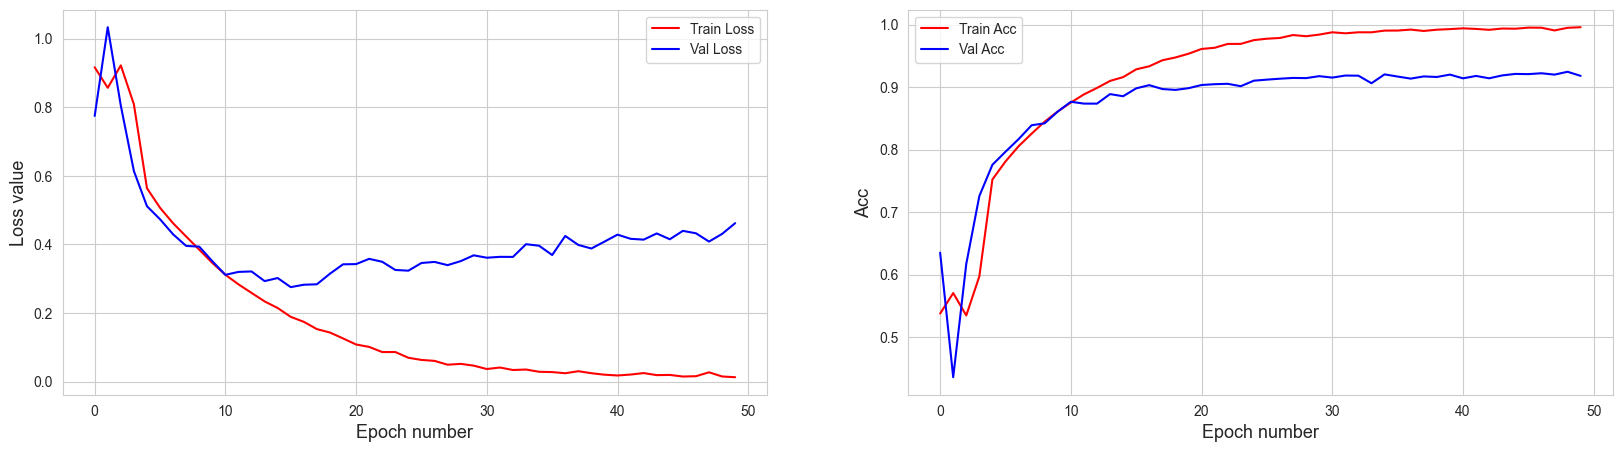

在测试集上的预测精度为： 0.9246070869338282
混淆矩阵:
 [[5203  173  172]
 [  80 4713  430]
 [ 120  325 6027]]


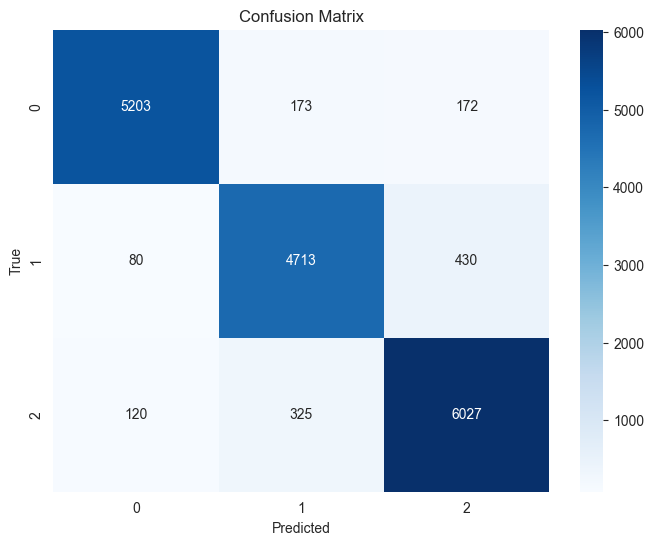

分类报告:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      5548
           1       0.90      0.90      0.90      5223
           2       0.91      0.93      0.92      6472

    accuracy                           0.92     17243
   macro avg       0.93      0.92      0.92     17243
weighted avg       0.93      0.92      0.92     17243

正在搜索参数: batch_size=64, hidden_size=128, lr=0.001, num_layers=2, dropout_rate=0.1, epochs=100
---------------
第 1/100 轮训练
第 1 轮训练 - 训练损失: 0.8498 - 训练精度: 0.5737
第 1 轮训练 - 验证损失: 1.0264 - 验证精度: 0.4529
---------------
第 2/100 轮训练
第 2 轮训练 - 训练损失: 0.6748 - 训练精度: 0.6802
第 2 轮训练 - 验证损失: 0.5786 - 验证精度: 0.7405
---------------
第 3/100 轮训练
第 3 轮训练 - 训练损失: 0.5707 - 训练精度: 0.7460
第 3 轮训练 - 验证损失: 0.5439 - 验证精度: 0.7639
---------------
第 4/100 轮训练
第 4 轮训练 - 训练损失: 0.4927 - 训练精度: 0.7884
第 4 轮训练 - 验证损失: 0.4377 - 验证精度: 0.8131
---------------
第 5/100 轮训练
第 5 轮训练 - 训练损失: 0.4286 - 训练精度: 0.8218
第 5 轮训练 - 验证损失: 0.4264 - 验证精度: 0.8287

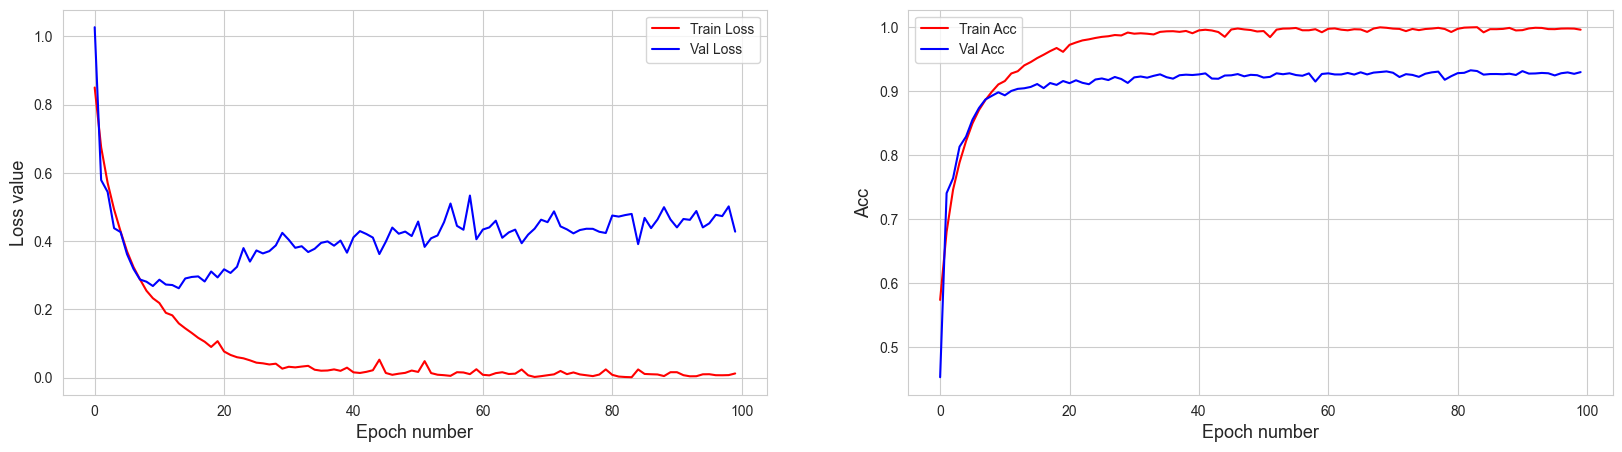

在测试集上的预测精度为： 0.93249434553152
混淆矩阵:
 [[5337  129   82]
 [ 148 4771  304]
 [ 179  322 5971]]


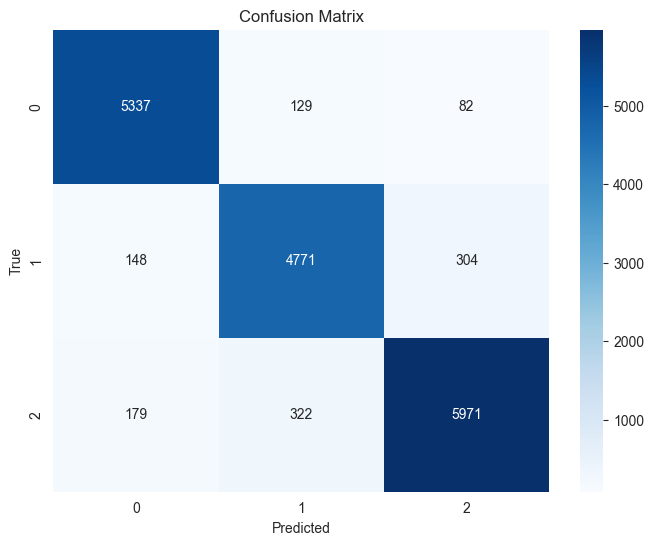

分类报告:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      5548
           1       0.91      0.91      0.91      5223
           2       0.94      0.92      0.93      6472

    accuracy                           0.93     17243
   macro avg       0.93      0.93      0.93     17243
weighted avg       0.93      0.93      0.93     17243

正在搜索参数: batch_size=64, hidden_size=128, lr=0.001, num_layers=2, dropout_rate=0.1, epochs=150
---------------
第 1/150 轮训练
第 1 轮训练 - 训练损失: 0.8297 - 训练精度: 0.5895
第 1 轮训练 - 验证损失: 0.6927 - 验证精度: 0.6693
---------------
第 2/150 轮训练
第 2 轮训练 - 训练损失: 0.6748 - 训练精度: 0.6825
第 2 轮训练 - 验证损失: 0.5993 - 验证精度: 0.7478
---------------
第 3/150 轮训练
第 3 轮训练 - 训练损失: 0.5543 - 训练精度: 0.7500
第 3 轮训练 - 验证损失: 0.5311 - 验证精度: 0.7694
---------------
第 4/150 轮训练
第 4 轮训练 - 训练损失: 0.4945 - 训练精度: 0.7830
第 4 轮训练 - 验证损失: 0.4595 - 验证精度: 0.8007
---------------
第 5/150 轮训练
第 5 轮训练 - 训练损失: 0.4514 - 训练精度: 0.8050
第 5 轮训练 - 验证损失: 0.4385 - 验证精度: 0.8094

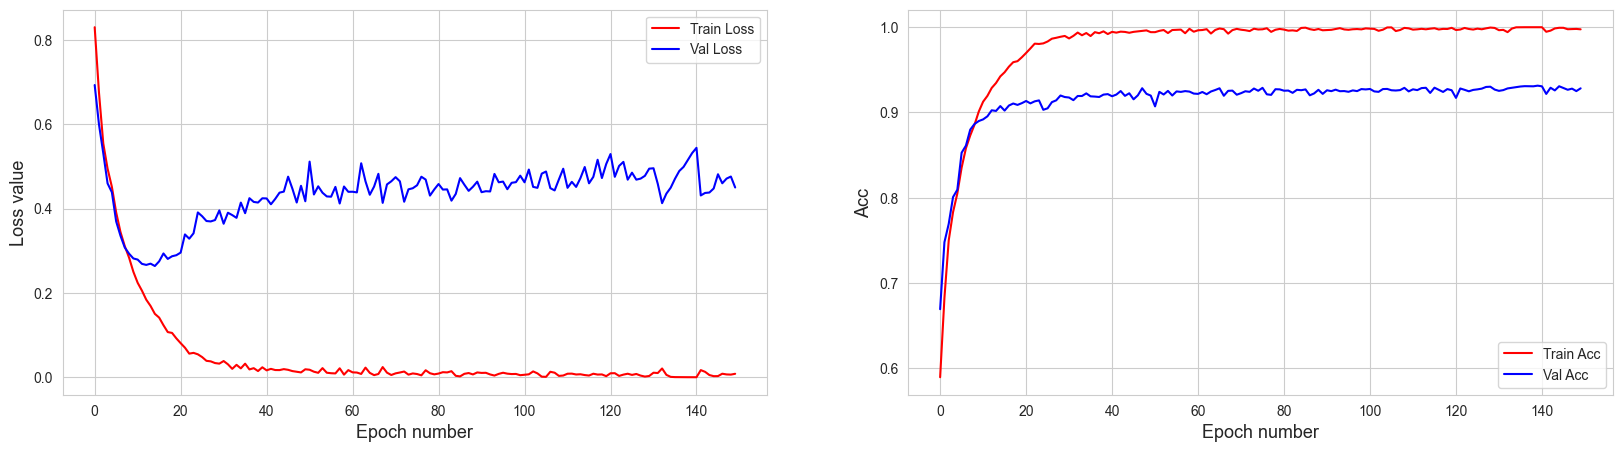

在测试集上的预测精度为： 0.9314504436582961
混淆矩阵:
 [[5350   96  102]
 [ 130 4775  318]
 [ 180  356 5936]]


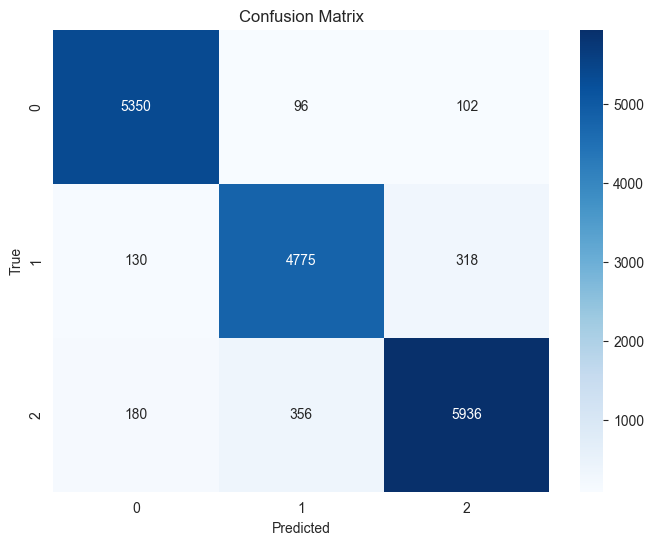

分类报告:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      5548
           1       0.91      0.91      0.91      5223
           2       0.93      0.92      0.93      6472

    accuracy                           0.93     17243
   macro avg       0.93      0.93      0.93     17243
weighted avg       0.93      0.93      0.93     17243

最佳模型保存成功！


In [52]:
Train_loader, Test_loader = Data_Loader(train_dataset, test_dataset, batch_size, collate_fn) 
# 实例化模型，这里需要添加Dropout层
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)       
# 训练模型，这里需要修改train_model2函数以接受额外的参数
model, train_process, Name = train_model2(device, model, Train_loader, Test_loader, criterion, optimizer, batch_size, hidden_size, lr, num_layers, dropout_rate, num_epochs=epochs)
Save_Path = Name.replace('Best_LSTM_Weight', 'LSTM_Loss_Acc_Curve').replace('.pth', '.jpg')
Draw(train_process, Save_Path)
# 评估模型在测试集上的性能
# 确保模型在正确的设备上
# 加载最佳模型参数
model.load_state_dict(torch.load(Name))
model.to(device)
model.eval()  # 设置模型为评估模式
test_y_all = torch.LongTensor().to(device)  # 将测试标签张量移动到设备上
pre_lab_all = torch.LongTensor().to(device)  # 将预测标签张量移动到设备上
_, Test_loader = Data_Loader(train_dataset, test_dataset, batch_size, collate_fn)
with torch.no_grad():
    for step, (textdata, lengths, target, _) in enumerate(Test_loader):
        out = model(textdata.to(device), lengths.to(device))  # 确保模型和数据都在同一个设备上
        pre_lab = torch.argmax(out, 1)
        test_y_all = torch.cat((test_y_all, target.to(device)), dim=0)
        pre_lab_all = torch.cat((pre_lab_all, pre_lab), dim=0)
# 将张量从设备移回CPU进行计算
test_acc = accuracy_score(test_y_all.cpu().numpy(), pre_lab_all.cpu().numpy())
print("在测试集上的预测精度为：", test_acc)
# 计算混淆矩阵
conf_mat = confusion_matrix(test_y_all.cpu().numpy(), pre_lab_all.cpu().numpy())
print("混淆矩阵:\n", conf_mat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(Save_Path.replace('LSTM_Loss_Acc_Curve', 'LSTM_CM'))
plt.show()
# 生成分类报告
report = classification_report(test_y_all.cpu().numpy(), pre_lab_all.cpu().numpy())
print("分类报告:\n", report)
